In [1]:
import cv2
import toml
import sys
import os
import time
import json
import numpy as np
from IPython.display import display, Image

sys.path.append(os.path.abspath("data_management"))
sys.path.append(os.path.abspath("onnx_models"))
sys.path.append(os.path.abspath("hardware"))

import data_preprocessing as dprep
import data_postprocessing as dpostp
import onnx_inference as onnx_inf
import fpgaconvnet_driver as hw_part

%matplotlib inline

In [2]:
yolo_cfg = toml.load('yolov5n.toml')
inf_exec = yolo_cfg['inf_exec']
imgsz = yolo_cfg['input_data']['imgsz']
conf_thres = yolo_cfg['predictor']['conf_thres']
iou_thres = yolo_cfg['predictor']['iou_thres']
classes = yolo_cfg['predictor']['classes']
if not classes:
    classes = None
onnx_model_path = yolo_cfg['onnx_model_path']
if inf_exec == "fpga":
    onnx_model_path = f"{onnx_model_path.split('.onnx')[0]}_head.onnx"
visualize = yolo_cfg['visualize']
out_img_path = yolo_cfg['out_img_path']
input_source = yolo_cfg['source']
bitstream_path = yolo_cfg['hardware']['bitstream_path']
weights_lookup_table = yolo_cfg['hardware']['weights_lookup_table']
weights_path = yolo_cfg['hardware']['weights_path']

In [3]:
_, _, head_session, output_names = onnx_inf.load_model(onnx_model_path)
stride, names, session, output_names = onnx_inf.load_model("onnx_models/yolov5n.onnx")

In [ ]:
#########################
### fpgaConvNet Setup ###
#########################

# initialise partition
partition = hw_part.Partition(bitstream_path, 5) 

# add input buffers
partition.add_input_buffer(0, 0, [320, 320, 3], bp=8)

# add output buffers
partition.add_output_buffer(2, 2, [40, 40, 256], bp=10, streams=2)
partition.add_output_buffer(3, 3, [20, 20, 256], bp=10, streams=2)
partition.add_output_buffer(4, 4, [10, 10, 256], bp=10, streams=2)

# create fifos
partition.add_fifo(0, 0, 2, 40*40*64 , burst=6400)
partition.add_fifo(1, 1, 1, 20*20*128, burst=6400)

# # setup hardware
partition.reset_hardware()
# p.start_hardware()  

# get the lookup table for the weights
with open(weights_lookup_table, "r") as f:
    lookup = json.load(f)

# iterate over the weights
for layer, idx in lookup.items():

    # allocate weights and load them
    start_time = time.perf_counter() 
    partition.reload_weights(idx, f"{weights_path}/{layer}.dat")
    pred_time = (time.perf_counter() - start_time)*1000
    print(f"[{idx}] {layer} loaded! ({pred_time:.2f} ms)")

# setup hardware
partition.reset_hardware()
partition.start_hardware()  

In [ ]:
try:
    cap.release()
    cap.destroyAllWindows()
except Exception as e:
    print(e)
    pass

if input_source == 'webcam':
    cap = cv2.VideoCapture(0) 
    display_handle=display(None, display_id=True)
else:
    cap = cv2.VideoCapture(input_source)

# capture a frame 
ret, frame = cap.read()

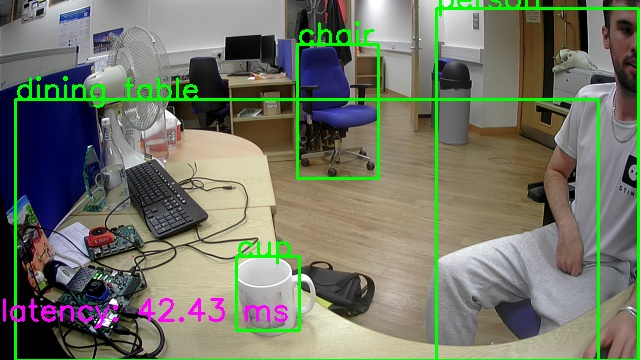

In [27]:
# original image
orig_img = frame.copy()

# perform pre-processing
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
img = dprep.img_preprocess(img, imgsz, stride)

# run fpgaconvnet
out0, out1, out2, pred_time = hw_part.run_fpgaconvnet(partition, img[0])

start_time = time.perf_counter() 
# run the onnx head
predictions = head_session.run(output_names, {
    "/model.24/m.0/Conv_output_0": np.expand_dims(out0[:255,:,:], axis=0),
    "/model.24/m.1/Conv_output_0": np.expand_dims(out1[:255,:,:], axis=0),
    "/model.24/m.2/Conv_output_0": np.expand_dims(out2[:255,:,:], axis=0),
})[0]      
pred_time += (time.perf_counter() - start_time)*1000  

predictions = dpostp.yolo_nms(predictions, conf_thres, iou_thres, classes)

for pred in predictions:

    pred[:, :4] = dpostp.scale_boxes((imgsz, imgsz), pred[:, :4], orig_img.shape).round()

    for p in pred:
        if visualize:
            cv2.rectangle(orig_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), (0, 255, 0), 2)
            cv2.putText(orig_img, names[int(p[5])], (int(p[0]), int(p[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# add the time for inference
cv2.putText(orig_img, f"latency: {pred_time:.2f} ms", (0, imgsz), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)

_, disp_img = cv2.imencode('.jpeg', orig_img)
display(Image(data=disp_img.tobytes()))

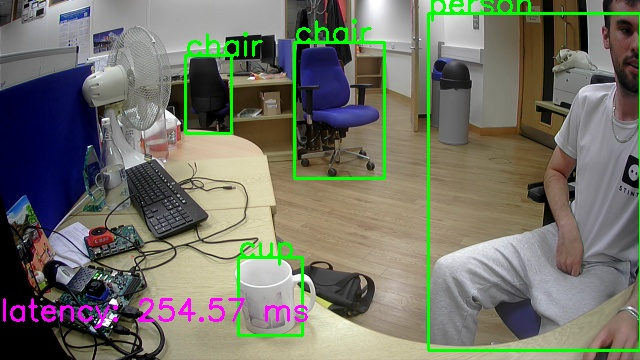

In [28]:
# original image
orig_img = frame.copy()

# perform pre-processing
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
img = dprep.img_preprocess(img, imgsz, stride)    
    
predictions, pred_time = onnx_inf.model_inf(img, session, output_names)

predictions = dpostp.yolo_nms(predictions, conf_thres, iou_thres, classes)

for pred in predictions:

    pred[:, :4] = dpostp.scale_boxes((imgsz, imgsz), pred[:, :4], orig_img.shape).round()

    for p in pred:
        if visualize:
            cv2.rectangle(orig_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), (0, 255, 0), 2)
            cv2.putText(orig_img, names[int(p[5])], (int(p[0]), int(p[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# add the time for inference
cv2.putText(orig_img, f"latency: {pred_time:.2f} ms", (0, imgsz), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)

_, disp_img = cv2.imencode('.jpeg', orig_img)
display(Image(data=disp_img.tobytes()))